#Trabajo Prático n°3 - Aritmética de píxeles 

Podemos combinar las imágenes con dos tipos de operaciones: las *cuasi-sumas* y las *cuasi-restas*. Supongamos que tenemos dos imágenes A y B que queremos combinarlas en una tercera imagen C.

* **Cuasi-suma**: implica la superposición de imágenes. Estas pueden ser

 * **Suma clampeada**: esta implica sumar independientemente los tres canales primarios, y coercionar independientemente cada uno si se pasa de 255. Sin embargo, de esta fora se da el problema de la *deriva cromática* (o color shift), es decir, los colores se alteran.

 * **Suma promediada**: la suma es el promedio de los canales primarios de las imágenes A y B independientemente. Sin embargo, la imagen tiende a verse más oscura que las originales.

* **Cuasi-resta**: implica realzar y comparar las diferencias entre las imágenes intervinientes. De igual forma que las cuasi-sumas, la resta puede ser clampeada o promediada, con algunas pequeñas diferencias a sus análogas.

 * **Resta clampeada**: aquí el clamping se realiza inferiormente, es decir, se coerciona el resultado de la diferencia a 0 en caso de que quede por debajo.

  * **Resta promediada**: en este caso se realiza una "diferencia promedio", donde el resultado de la diferencia, en un intervalo de [-255, 255], se divide por 2, y a este valor se lo desplaza en 128 valores. De esta forma, el valore final queda en el intervalo [0, 255].

En el espacio YIQ, es posible realizar las mismas operaciones, con la ventaja de que se puede simplificar los problemas. Debido a que la luminancia y la cromaticidad están separadas, podemos operar las imágenes sin alterar los colores de la misma, haciendo suma clampeada o promediada sólo sobre la luminancia.
Para afectar coherentemente la cromaticidad, se aplica la regla del paralelogramo, es decir, una "combinación lineal" de los estímulos intervinientes, ponderados por la luminancia de cada estímulo. Esto es

$$ I_C = \dfrac{Y_A * I_A + Y_B * I_B}{Y_A + Y_B} $$

$$ Q_C = \dfrac{Y_A * Q_A + Y_B * Q_B}{Y_A + Y_B} $$

Operar en el espacio YIQ permite, además, otros dos tipos de operaciones de suma y resta. En este caso, hablamos de la suma "if-lighter" y resta "if-darker":

* **If lighter**: el pixel en la imagen resultante retiene los valores de pixel de las imágenes A y B que tenga mayor luminancia.

* **If-darker**: de forma análoga, se puede retener los valores de pixel que tenga menor luminancia.


In [1]:
#Mounting 
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


Images: 


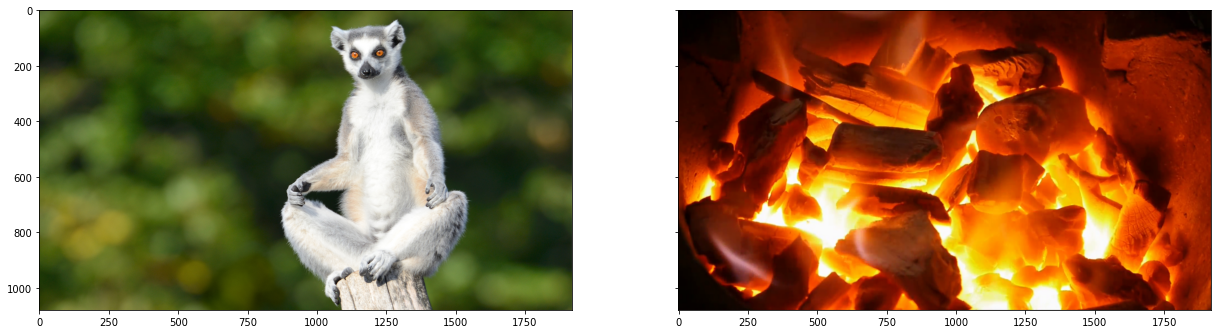

In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

drive_dir = '/content/gdrive/My Drive/Doctorado/PDI/images/' #Directory

#UPLOADING IMAGE AS A NUMPY IMAGE
img_A = imageio.imread(drive_dir + 'lemuranillado.jpg')
img_B = imageio.imread(drive_dir + 'fire.png')
print("Images: ")
#PLOTTING
fig_main, axs_main = plt.subplots(1, 2, sharey=True, figsize=(img_A.shape[0]//50, img_A.shape[1]//50))
axs_main[0].imshow(img_A)
axs_main[1].imshow(img_B)
plt.show()


In [3]:
#CONVERSION BETWEEN RGB AND YIQ SPACES
def RGBtoYIQ(img_rgb):
  coef = np.array([[   0.299,     0.587,     0.114],
                   [0.595716, -0.274453, -0.321263],
                   [0.211456, -0.522591,  0.311135]])
  
  img_norm = img_rgb / 255 #Normalization of RGB vector
  dims = img_rgb.shape
  img_yiq = np.zeros(dims)
  for i in range(dims[0]):
    for j in range(dims[1]):
      img_yiq[i, j, :] = np.matmul(coef, img_norm[i, j, :])
  np.clip(img_yiq[:,:,0],       0,      1, out=img_yiq[:,:,0])  #       0 <= Y <= 1
  np.clip(img_yiq[:,:,1], -0.5957, 0.5957, out=img_yiq[:,:,1])  # -0.5957 <= I <= 0.5957
  np.clip(img_yiq[:,:,2], -0.5226, 0.5226, out=img_yiq[:,:,2])  # -0.5226 <= Q <= 0.5226
  return img_yiq

def YIQtoRGB(img_yiq):
  coef = np.array([[1,  0.9663,  0.6210],
                   [1, -0.2721, -0.6474],
                   [1, -1.1070,  1.7046]])
  
  dims = img_yiq.shape
  img_norm_rgb = np.zeros(dims)
  for i in range(dims[0]):
    for j in range(dims[1]):
      img_norm_rgb[i, j, :] = np.matmul(coef, img_yiq[i, j, :])
  np.clip(img_norm_rgb, 0, 1, out=img_norm_rgb)
  return np.uint8(np.floor(img_norm_rgb * 255)) #De-normalization of normalized RGB vector

In [6]:
def set_operation_context(img_A, img_B):
  dims_A = img_A.shape
  dims_B = img_B.shape
  img_A_norm = img_A / 255
  img_B_norm = img_B / 255
  yiq_A = RGBtoYIQ(img_A)
  yiq_B = RGBtoYIQ(img_B)

  def operate_images(rgb_op_type, yiq_op_type):
    #RGB SPACE OPERATIONS
    img_C_norm = np.zeros(dims_A)
    img_C_RGB = np.zeros(dims_A)
    if rgb_op_type == 'Suma clampeada':
      img_C_norm[:] = img_A_norm + img_B_norm
    elif rgb_op_type == 'Resta clampeada':
      img_C_norm[:] = img_A_norm - img_B_norm
    elif rgb_op_type == 'Suma promediada':
      img_C_norm[:] = (img_A_norm + img_B_norm) / 2
    elif rgb_op_type == 'Resta promediada':
      img_C_norm[:] = (img_A_norm - img_B_norm) // 2 + 0.5
        
    #CLIPPING
    np.clip(img_C_norm, 0, 1, out=img_C_norm)
    np.clip(np.floor(img_C_norm * 255), 0, 255, out=img_C_RGB)
    
    #YIQ SPACE OPERATIONS
    yiq_C = np.zeros(dims_A)
    if yiq_op_type[:2] == 'if':
      if yiq_op_type == 'if-lighter':
        yiq_C[:,:, 0] = np.where(yiq_A[:, :, 0] > yiq_B[:, :, 0], yiq_A[:, :, 0], yiq_B[:, :, 0])
        yiq_C[:,:, 1] = np.where(yiq_A[:, :, 0] > yiq_B[:, :, 0], yiq_A[:, :, 1], yiq_B[:, :, 1])
        yiq_C[:,:, 2] = np.where(yiq_A[:, :, 0] > yiq_B[:, :, 0], yiq_A[:, :, 2], yiq_B[:, :, 2])
      elif yiq_op_type == 'if-darker':
        yiq_C[:,:, 0] = np.where(yiq_A[:, :, 0] < yiq_B[:, :, 0], yiq_A[:, :, 0], yiq_B[:, :, 0])
        yiq_C[:,:, 1] = np.where(yiq_A[:, :, 0] < yiq_B[:, :, 0], yiq_A[:, :, 1], yiq_B[:, :, 1])
        yiq_C[:,:, 2] = np.where(yiq_A[:, :, 0] < yiq_B[:, :, 0], yiq_A[:, :, 2], yiq_B[:, :, 2])
    else:
      if yiq_op_type == 'Suma clampeada':
        yiq_C[:, :, 0] = yiq_A[:, :, 0] + yiq_B[:, :, 0]
      elif yiq_op_type == 'Resta clampeada':
        yiq_C[:, :, 0] = yiq_A[:, :, 0] - yiq_B[:, :, 0]
      elif yiq_op_type == 'Suma promediada':
        yiq_C[:, :, 0] = (yiq_A[:, :, 0] + yiq_B[:, :, 0]) / 2
      elif yiq_op_type == 'Resta promediada':
        yiq_C[:, :, 0] = (yiq_A[:, :, 0] - yiq_B[:, :, 0]) / 2 + 0.5
        
      np.clip(yiq_C[:, :, 0], 0, 1, out=yiq_C[:, :, 0])
      yiq_C[:, :, 1] = (yiq_A[:, :, 0] * yiq_A[:, :, 1] + yiq_B[:, :, 0] * yiq_B[:, :, 1]) / (yiq_A[:, :, 0] + yiq_B[:, :, 0])
      yiq_C[:, :, 2] = (yiq_A[:, :, 0] * yiq_A[:, :, 2] + yiq_B[:, :, 0] * yiq_B[:, :, 2]) / (yiq_A[:, :, 0] + yiq_B[:, :, 0])

    img_C_YIQ = YIQtoRGB(yiq_C)
    
    #RETURN IMAGE
    return np.uint8(img_C_RGB), img_C_YIQ
  
  #RETURN SETTED FUNCTION
  return operate_images
      
operate_imgs = set_operation_context(img_A, img_B)


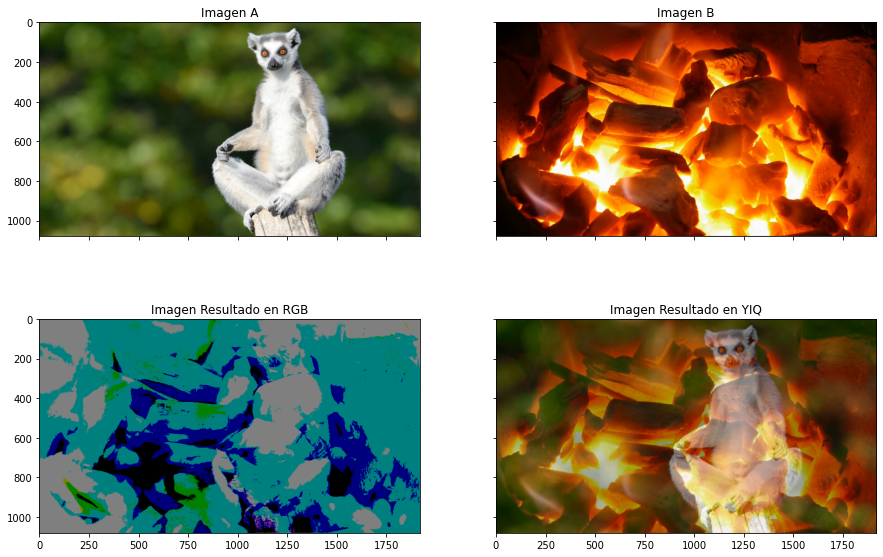

In [13]:
#@title Suma y resta de imágenes {run:"auto"}
rgb_op = 'Resta promediada' #@param ['Suma clampeada','Resta clampeada', 'Suma promediada', 'Resta promediada']
yiq_op = 'Suma promediada' #@param ['Suma clampeada','Resta clampeada', 'Suma promediada', 'Resta promediada', 'if-lighter', 'if-darker']

img_RGB, img_YIQ = operate_imgs(rgb_op, yiq_op)

#PLOTTING
fig_results, axs_results = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,10))
#figsize=(img_A.shape[0], img_A.shape[1])
axs_results[0, 0].imshow(img_A)
axs_results[0, 0].set_title("Imagen A")
axs_results[0, 1].imshow(img_B)
axs_results[0, 1].set_title("Imagen B")
axs_results[1, 0].imshow(img_RGB)
axs_results[1, 0].set_title("Imagen Resultado en RGB")
axs_results[1, 1].imshow(img_YIQ)
axs_results[1, 1].set_title("Imagen Resultado en YIQ")
plt.show()

## Resultados

### Operaciones en el espacio RGB

* **Suma clampeada**: en términos generales, la imagen resultante es más luminosa que las imágenes generales, esperable debido a que los valores de los canales son la suma de los originales. Particularmente para estas imágenes no puede verse el fenomeno de la deriva cromática. Sólo en las zonas donde coinciden los blancos de ambas imágenes se aprecia una imagen resultante quemada en esas mismas zonas.

* **Resta clampeada**: en contraposición a la suma, la imagen resultante tiende a ser más oscura, y es importante destacar el orden en que estas imágenes se operan. En este caso a la imagen del lémur se le resta la imagen de la hoguera, y en ese sentido se realiza un análisis.
 * Por un lado, las zonas más oscuras de la imagen de la hoguera, no alteran o alteran insignificantemente las zonas correspondientes en la imagen del lémur. Las esquinas de la imagen resultante conservan los colores de la imagen del animal, por ejemplo.
 * En las zonas correspondientes a las de mayor intensidad en la imagen de la hoguera (esto es, donde los valores de los canales son más altos que en la imagen del lémur) se produce deriva cromática, ya que los canales en la imagen resultante son nulos.

* **Suma promediada**: aquí, esta operación da una imagen más oscura como era de esperarse. Cabe destacar que con la suma promediada en el espacio RGB se obtiene la misma imagen resultando que la suma promediada en el espacio YIQ.

* **Resta promediada**: la imagen no tiene una interpretación sencilla, y puede que requiera utilizar en casos más específicos.

## Operaciones en el espacio YIQ

* **Suma clampeada**: de la misma forma, podemos ver que la imagen resultante es mucho más luminosa que las originales, pero con la diferencia de que las imágenes están "bien superpuestas". Esto es, ambas imágenes conforman la imagen resultante, sin por ello caer en la deriva cromática en las zonas más luminosas, es decir, se conservan (o son más predominantes) los colores cuya luminancia es más alta.

* **Resta clampeada**: nuevamente, no ocurre deriva cromática, y la luminancia es esperablemente más baja que en el caso de la suma. Como la luminancia de la imagen de la hoguera "está invertida", las zonas más luminosas allí son las zonas más oscuras en la imagen resultante.

* **Suma promediada**: teniendo la ventaja de tener la luminancia y cromaticidad separadas, vemos que la deriva cromática desaparece, y queda una superposición de las imágenes más oscurecida, en contraste con la suma clampeada.

* **Resta promediada**: suponiendo que la imagen que estamos restando es una especie de "negativo" de la luminancia, podemos ver cómo las zonas más oscuras de la imagen de la hoguera se corresponde con la más luminosa en la imagen resultante, y viceversa.

* **If-lighter**: aquí puede verse claramente que la cromaticidad conservada en la imagen resultante es la que sea más luminosa de las dos imágenes.

* **If-darker**: análogamente, la imagen resultante se conforma de las cromaticidades más oscuras de las imágenes resultantes.